Import necessary dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [4]:
data = pd.read_csv('IoT_Modbus.csv')

# TODO: Complete EDA

Combine 'date' and 'time' into a single datetime column

In [5]:
data['date'] = data['date'].str.strip()
data['time'] = data['time'].str.strip()
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%b-%y %H:%M:%S')

Extract time features

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Data preprocessing (Normalization)

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = MinMaxScaler()

X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229755 entries, 541 to 184368
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 11.4 MB


# Execution model
## Create model

In [11]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(adjusted_hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        out = self.fc(last_time_step_out)
        return out

Initialize model

In [12]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 0.5

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

In [13]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [14]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Construct Data Loader

In [15]:
batch_size = 128

# Use to_numpy is much better than .values
X_train_tensor: torch.Tensor = torch.tensor(X_train.to_numpy()).float().unsqueeze(1).to(device)
X_test_tensor: torch.Tensor = torch.tensor(X_test.to_numpy()).float().unsqueeze(1).to(device)

y_train_tensor: torch.Tensor = torch.tensor(y_train.to_numpy()).float().unsqueeze(1).to(device)
y_test_tensor: torch.Tensor = torch.tensor(y_test.to_numpy()).float().unsqueeze(1).to(device)


train_dataset: torch.utils.data.dataset.TensorDataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader: torch.utils.data.dataloader.DataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset: torch.utils.data.dataset.TensorDataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader: torch.utils.data.dataloader.DataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training model

In [20]:
num_epochs = 89
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
loss_list_train = [None] * num_epochs


for epoch in range(num_epochs):
    model.train()
    loss_storage = 0
    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_storage += loss.item() * inputs.size(0)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate indicators
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            probabilities = torch.sigmoid(outputs)

            loss = criterion(probabilities, labels)

            # Calculate indicators
            running_loss += loss.item() * inputs.size(0)

            predictions = (probabilities > 0.5).float().to(device)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_train_loss = loss_storage / len(train_loader.dataset)
    epoch_val_loss = running_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)

    loss_list[epoch] = epoch_val_loss
    acc_list[epoch] = accuracy

    pbar.update(1)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss_train: {epoch_train_loss}, Loss_test: {epoch_val_loss}, Accuracy_test: {accuracy}')

pbar.close()

  1%|          | 1/89 [00:09<13:57,  9.52s/it]

Epoch [1/89], Loss_train: 0.22612605195878493, Loss_test: 1.486477214381581, Accuracy_test: 0.8171103257368687


  2%|▏         | 2/89 [00:17<12:53,  8.89s/it]

Epoch [2/89], Loss_train: 0.22685452589734803, Loss_test: 1.4905468112929816, Accuracy_test: 0.8117829349396751


  3%|▎         | 3/89 [00:26<12:13,  8.53s/it]

Epoch [3/89], Loss_train: 0.22152871339769706, Loss_test: 1.4846826518992593, Accuracy_test: 0.8203137241247236


  4%|▍         | 4/89 [00:34<11:49,  8.34s/it]

Epoch [4/89], Loss_train: 0.220454271852407, Loss_test: 1.478925205642241, Accuracy_test: 0.8247706262295653


  6%|▌         | 5/89 [00:42<11:32,  8.25s/it]

Epoch [5/89], Loss_train: 0.2165921847978526, Loss_test: 1.4710532666481326, Accuracy_test: 0.8333014154146138


  7%|▋         | 6/89 [00:50<11:18,  8.17s/it]

Epoch [6/89], Loss_train: 0.2168676636326427, Loss_test: 1.4629549382819997, Accuracy_test: 0.839412246034924


  8%|▊         | 7/89 [00:58<11:04,  8.10s/it]

Epoch [7/89], Loss_train: 0.2121539583099214, Loss_test: 1.454755805848267, Accuracy_test: 0.8511464336078274


  9%|▉         | 8/89 [01:06<10:56,  8.11s/it]

Epoch [8/89], Loss_train: 0.22227097131034862, Loss_test: 1.4490877455677478, Accuracy_test: 0.8537753094587301


 10%|█         | 9/89 [01:14<10:55,  8.19s/it]

Epoch [9/89], Loss_train: 0.2101269669548938, Loss_test: 1.4520718566006456, Accuracy_test: 0.8608088580929334


 11%|█         | 10/89 [01:23<10:50,  8.24s/it]

Epoch [10/89], Loss_train: 0.2609624579619397, Loss_test: 1.481186670858458, Accuracy_test: 0.806664461428646


 12%|█▏        | 11/89 [01:30<10:24,  8.00s/it]

Epoch [11/89], Loss_train: 0.23275350218589233, Loss_test: 1.4606493724318326, Accuracy_test: 0.8619056738452967


 13%|█▎        | 12/89 [01:37<10:03,  7.84s/it]

Epoch [12/89], Loss_train: 0.22644743320388092, Loss_test: 1.4774128819025003, Accuracy_test: 0.8046797472100837


 15%|█▍        | 13/89 [01:46<10:18,  8.13s/it]

Epoch [13/89], Loss_train: 0.20930096684807922, Loss_test: 1.4407796345912003, Accuracy_test: 0.8732742561674124


 16%|█▌        | 14/89 [01:54<09:59,  7.99s/it]

Epoch [14/89], Loss_train: 0.24662637473447896, Loss_test: 1.4605550974071493, Accuracy_test: 0.8266682915788924


 17%|█▋        | 15/89 [02:02<09:44,  7.90s/it]

Epoch [15/89], Loss_train: 0.21104295258101166, Loss_test: 1.4498470229573228, Accuracy_test: 0.8628806211807308


 18%|█▊        | 16/89 [02:09<09:24,  7.74s/it]

Epoch [16/89], Loss_train: 0.230796048674212, Loss_test: 1.4385737024535479, Accuracy_test: 0.8544542906387647


 19%|█▉        | 17/89 [02:16<09:08,  7.62s/it]

Epoch [17/89], Loss_train: 0.19752699896949455, Loss_test: 1.4426585172269895, Accuracy_test: 0.8659795609255035


 20%|██        | 18/89 [02:24<08:54,  7.52s/it]

Epoch [18/89], Loss_train: 0.22916516823854463, Loss_test: 1.4279636635139699, Accuracy_test: 0.8709935757934505


 21%|██▏       | 19/89 [02:31<08:42,  7.46s/it]

Epoch [19/89], Loss_train: 0.19745510316774545, Loss_test: 1.4572386333115115, Accuracy_test: 0.8473162833614791


 22%|██▏       | 20/89 [02:38<08:33,  7.44s/it]

Epoch [20/89], Loss_train: 0.20710222369917552, Loss_test: 1.4285805823068711, Accuracy_test: 0.8724908163442957


 24%|██▎       | 21/89 [02:46<08:24,  7.42s/it]

Epoch [21/89], Loss_train: 0.19415194672686908, Loss_test: 1.4499951324459737, Accuracy_test: 0.8533922944340953


 25%|██▍       | 22/89 [02:53<08:15,  7.39s/it]

Epoch [22/89], Loss_train: 0.1884524537630722, Loss_test: 1.4545325376784108, Accuracy_test: 0.8474207420045614


 26%|██▌       | 23/89 [03:00<08:07,  7.38s/it]

Epoch [23/89], Loss_train: 0.18323043739302727, Loss_test: 1.475502761240181, Accuracy_test: 0.8353035394070231


 27%|██▋       | 24/89 [03:08<07:58,  7.36s/it]

Epoch [24/89], Loss_train: 0.17941602668677395, Loss_test: 1.4849924204830556, Accuracy_test: 0.8334929229269312


 28%|██▊       | 25/89 [03:15<07:50,  7.35s/it]

Epoch [25/89], Loss_train: 0.17369141584034245, Loss_test: 1.5043007267283335, Accuracy_test: 0.8203659534462647


 29%|██▉       | 26/89 [03:22<07:43,  7.36s/it]

Epoch [26/89], Loss_train: 0.1729388117930003, Loss_test: 1.4942448115178217, Accuracy_test: 0.8305332613729348


 30%|███       | 27/89 [03:30<07:35,  7.35s/it]

Epoch [27/89], Loss_train: 0.1646360145209532, Loss_test: 1.5224163374484658, Accuracy_test: 0.8043837810546841


 31%|███▏      | 28/89 [03:37<07:28,  7.35s/it]

Epoch [28/89], Loss_train: 0.16087629238057458, Loss_test: 1.4920038865754426, Accuracy_test: 0.8428419714827904


 33%|███▎      | 29/89 [03:44<07:22,  7.37s/it]

Epoch [29/89], Loss_train: 0.1558178351831103, Loss_test: 1.5462446087600772, Accuracy_test: 0.7853200786921778


 34%|███▎      | 30/89 [03:52<07:14,  7.36s/it]

Epoch [30/89], Loss_train: 0.16442475892134853, Loss_test: 1.538469055736689, Accuracy_test: 0.8010411044760528


 35%|███▍      | 31/89 [04:00<07:23,  7.64s/it]

Epoch [31/89], Loss_train: 0.15320107751275797, Loss_test: 1.517055533666934, Accuracy_test: 0.8187816640261844


 36%|███▌      | 32/89 [04:09<07:32,  7.94s/it]

Epoch [32/89], Loss_train: 0.15529385788569702, Loss_test: 1.4872986108708546, Accuracy_test: 0.8422152196242971


 37%|███▋      | 33/89 [04:16<07:21,  7.88s/it]

Epoch [33/89], Loss_train: 0.1494101069954851, Loss_test: 1.5014883856223893, Accuracy_test: 0.8250665923849649


 38%|███▊      | 34/89 [04:27<07:51,  8.58s/it]

Epoch [34/89], Loss_train: 0.1521301468290962, Loss_test: 1.4851883542652045, Accuracy_test: 0.8456275352983165


 39%|███▉      | 35/89 [04:35<07:43,  8.59s/it]

Epoch [35/89], Loss_train: 0.1481917249362453, Loss_test: 1.482260670068194, Accuracy_test: 0.8416581068611919


 40%|████      | 36/89 [04:44<07:28,  8.47s/it]

Epoch [36/89], Loss_train: 0.14745544656746123, Loss_test: 1.4833508445251145, Accuracy_test: 0.8436776406274482


 42%|████▏     | 37/89 [04:51<07:10,  8.28s/it]

Epoch [37/89], Loss_train: 0.14796922337637683, Loss_test: 1.4683998842944521, Accuracy_test: 0.8529396403140723


 43%|████▎     | 38/89 [04:59<06:58,  8.21s/it]

Epoch [38/89], Loss_train: 0.1442791942603373, Loss_test: 1.4829161512035873, Accuracy_test: 0.8395167046780062


 44%|████▍     | 39/89 [05:07<06:48,  8.17s/it]

Epoch [39/89], Loss_train: 0.14745702000719038, Loss_test: 1.4740941375678196, Accuracy_test: 0.8512334824770627


 45%|████▍     | 40/89 [05:16<06:38,  8.13s/it]

Epoch [40/89], Loss_train: 0.14401902354975138, Loss_test: 1.4692896453095532, Accuracy_test: 0.8506763697139574


 46%|████▌     | 41/89 [05:23<06:27,  8.07s/it]

Epoch [41/89], Loss_train: 0.14251091819235653, Loss_test: 1.4731788806495718, Accuracy_test: 0.8494228659969707


 47%|████▋     | 42/89 [05:31<06:15,  8.00s/it]

Epoch [42/89], Loss_train: 0.14279065371325134, Loss_test: 1.4571181266436797, Accuracy_test: 0.8599209596267344


 48%|████▊     | 43/89 [05:40<06:13,  8.11s/it]

Epoch [43/89], Loss_train: 0.13946876329234678, Loss_test: 1.4744387928366436, Accuracy_test: 0.8416929264088859


 49%|████▉     | 44/89 [05:48<06:08,  8.18s/it]

Epoch [44/89], Loss_train: 0.1424502933860154, Loss_test: 1.4320916790104579, Accuracy_test: 0.8835634325110117


 51%|█████     | 45/89 [05:56<05:59,  8.17s/it]

Epoch [45/89], Loss_train: 0.14108496812103255, Loss_test: 1.48978419063894, Accuracy_test: 0.8301328365744529


 52%|█████▏    | 46/89 [06:04<05:43,  7.98s/it]

Epoch [46/89], Loss_train: 0.1453342448675117, Loss_test: 1.40791918375351, Accuracy_test: 0.9122025104893887


 53%|█████▎    | 47/89 [06:11<05:28,  7.81s/it]

Epoch [47/89], Loss_train: 0.14253520286285695, Loss_test: 1.4788570894927944, Accuracy_test: 0.8410487647765456


 54%|█████▍    | 48/89 [06:19<05:16,  7.72s/it]

Epoch [48/89], Loss_train: 0.15252577349862168, Loss_test: 1.4268518340822345, Accuracy_test: 0.8897961315482512


 55%|█████▌    | 49/89 [06:26<05:05,  7.63s/it]

Epoch [49/89], Loss_train: 0.13448811011896053, Loss_test: 1.4645316991847706, Accuracy_test: 0.8450878323090583


 56%|█████▌    | 50/89 [06:34<04:55,  7.59s/it]

Epoch [50/89], Loss_train: 0.14412216791028723, Loss_test: 1.4690796490505393, Accuracy_test: 0.85189505388325


 57%|█████▋    | 51/89 [06:41<04:46,  7.55s/it]

Epoch [51/89], Loss_train: 0.13826809812920554, Loss_test: 1.455171855886234, Accuracy_test: 0.8632288166576716


 58%|█████▊    | 52/89 [06:48<04:38,  7.54s/it]

Epoch [52/89], Loss_train: 0.1326011064482386, Loss_test: 1.443827155516812, Accuracy_test: 0.8750326433259632


 60%|█████▉    | 53/89 [06:56<04:29,  7.49s/it]

Epoch [53/89], Loss_train: 0.13408268703965542, Loss_test: 1.5225980077153218, Accuracy_test: 0.8061073486655408


 61%|██████    | 54/89 [07:03<04:23,  7.52s/it]

Epoch [54/89], Loss_train: 0.17024498061569351, Loss_test: 1.4482039701793559, Accuracy_test: 0.8682950608471596


 62%|██████▏   | 55/89 [07:11<04:16,  7.53s/it]

Epoch [55/89], Loss_train: 0.13181960327308342, Loss_test: 1.4693233200898523, Accuracy_test: 0.8459931405491042


 63%|██████▎   | 56/89 [07:18<04:07,  7.51s/it]

Epoch [56/89], Loss_train: 0.13522766171907438, Loss_test: 1.4592884101148589, Accuracy_test: 0.8575184108358432


 64%|██████▍   | 57/89 [07:27<04:05,  7.68s/it]

Epoch [57/89], Loss_train: 0.13790998608591043, Loss_test: 1.4601754285193442, Accuracy_test: 0.848186772053831


 65%|██████▌   | 58/89 [07:34<03:58,  7.69s/it]

Epoch [58/89], Loss_train: 0.1365233544264967, Loss_test: 1.445126841199807, Accuracy_test: 0.8627761625376487


 66%|██████▋   | 59/89 [07:42<03:51,  7.73s/it]

Epoch [59/89], Loss_train: 0.12869867264870533, Loss_test: 1.4515875956812896, Accuracy_test: 0.8525043959678964


 67%|██████▋   | 60/89 [07:50<03:43,  7.71s/it]

Epoch [60/89], Loss_train: 0.12158149252660022, Loss_test: 1.4631861689180428, Accuracy_test: 0.8526784937063667


 69%|██████▊   | 61/89 [07:57<03:33,  7.63s/it]

Epoch [61/89], Loss_train: 0.12832595287310056, Loss_test: 1.459999225876346, Accuracy_test: 0.8482564111492191


 70%|██████▉   | 62/89 [08:05<03:24,  7.59s/it]

Epoch [62/89], Loss_train: 0.13081467419312356, Loss_test: 1.4410756694342624, Accuracy_test: 0.8645519594700465


 71%|███████   | 63/89 [08:12<03:16,  7.56s/it]

Epoch [63/89], Loss_train: 0.12529697110824697, Loss_test: 1.4386430577080043, Accuracy_test: 0.8637162903253887


 72%|███████▏  | 64/89 [08:20<03:08,  7.55s/it]

Epoch [64/89], Loss_train: 0.12062753598275214, Loss_test: 1.4493215336092573, Accuracy_test: 0.8524173470986612


 73%|███████▎  | 65/89 [08:27<03:00,  7.53s/it]

Epoch [65/89], Loss_train: 0.12262410667089318, Loss_test: 1.4670835747381183, Accuracy_test: 0.8506763697139574


 74%|███████▍  | 66/89 [08:35<02:53,  7.53s/it]

Epoch [66/89], Loss_train: 0.12786635692897616, Loss_test: 1.4430191799090033, Accuracy_test: 0.873552812548965


 75%|███████▌  | 67/89 [08:42<02:45,  7.54s/it]

Epoch [67/89], Loss_train: 0.1203413642259506, Loss_test: 1.4440368748252448, Accuracy_test: 0.8671460157732551


 76%|███████▋  | 68/89 [08:50<02:39,  7.58s/it]

Epoch [68/89], Loss_train: 0.11741570012053354, Loss_test: 1.4506186270116503, Accuracy_test: 0.8566827416911854


 78%|███████▊  | 69/89 [08:58<02:32,  7.62s/it]

Epoch [69/89], Loss_train: 0.11894760371686627, Loss_test: 1.452230470787651, Accuracy_test: 0.8543150124479884


 79%|███████▊  | 70/89 [09:05<02:24,  7.61s/it]

Epoch [70/89], Loss_train: 0.11978572863079151, Loss_test: 1.4444420153546913, Accuracy_test: 0.8581625724681836


 80%|███████▉  | 71/89 [09:13<02:16,  7.59s/it]

Epoch [71/89], Loss_train: 0.11947411652437903, Loss_test: 1.4425702480227236, Accuracy_test: 0.8756593951844566


 81%|████████  | 72/89 [09:20<02:09,  7.60s/it]

Epoch [72/89], Loss_train: 0.11631741312643257, Loss_test: 1.4313608178226713, Accuracy_test: 0.8826929438186598


 82%|████████▏ | 73/89 [09:28<02:01,  7.58s/it]

Epoch [73/89], Loss_train: 0.1229780241768454, Loss_test: 1.4408066004883597, Accuracy_test: 0.87816640261843


 83%|████████▎ | 74/89 [09:36<01:53,  7.57s/it]

Epoch [74/89], Loss_train: 0.1242350028010467, Loss_test: 1.4179491842064316, Accuracy_test: 0.8896046240359338


 84%|████████▍ | 75/89 [09:43<01:47,  7.65s/it]

Epoch [75/89], Loss_train: 0.11707953781309138, Loss_test: 1.449823878120626, Accuracy_test: 0.8668674593917025


 85%|████████▌ | 76/89 [09:51<01:39,  7.64s/it]

Epoch [76/89], Loss_train: 0.12160015149102127, Loss_test: 1.4313255274046135, Accuracy_test: 0.8788802033461586


 87%|████████▋ | 77/89 [09:59<01:32,  7.70s/it]

Epoch [77/89], Loss_train: 0.11919333390833652, Loss_test: 1.4536198065281287, Accuracy_test: 0.8542976026741412


 88%|████████▊ | 78/89 [10:06<01:24,  7.69s/it]

Epoch [78/89], Loss_train: 0.11428027944916912, Loss_test: 1.450683543172337, Accuracy_test: 0.872160030641202


 89%|████████▉ | 79/89 [10:14<01:16,  7.65s/it]

Epoch [79/89], Loss_train: 0.11726366137363427, Loss_test: 1.444493064404854, Accuracy_test: 0.8757290342798447


 90%|████████▉ | 80/89 [10:22<01:08,  7.63s/it]

Epoch [80/89], Loss_train: 0.11714369420841164, Loss_test: 1.4369963538619925, Accuracy_test: 0.8802555754800745


 91%|█████████ | 81/89 [10:29<01:00,  7.59s/it]

Epoch [81/89], Loss_train: 0.11432864974204461, Loss_test: 1.43971008476095, Accuracy_test: 0.869426696147217


 92%|█████████▏| 82/89 [10:37<00:52,  7.57s/it]

Epoch [82/89], Loss_train: 0.1187014177328602, Loss_test: 1.456130663650726, Accuracy_test: 0.8695485645641463


 93%|█████████▎| 83/89 [10:44<00:45,  7.56s/it]

Epoch [83/89], Loss_train: 0.1191182596233936, Loss_test: 1.4157291720049172, Accuracy_test: 0.8988143944010167


 94%|█████████▍| 84/89 [10:52<00:37,  7.56s/it]

Epoch [84/89], Loss_train: 0.1185143661812667, Loss_test: 1.4545666993989483, Accuracy_test: 0.8704190532564982


 96%|█████████▌| 85/89 [10:59<00:30,  7.53s/it]

Epoch [85/89], Loss_train: 0.1170365010709683, Loss_test: 1.4153257077171826, Accuracy_test: 0.893399954734588


 97%|█████████▋| 86/89 [11:07<00:22,  7.54s/it]

Epoch [86/89], Loss_train: 0.11564194942445985, Loss_test: 1.446989382219654, Accuracy_test: 0.8673723428332666


 98%|█████████▊| 87/89 [11:14<00:15,  7.57s/it]

Epoch [87/89], Loss_train: 0.11519587584630227, Loss_test: 1.4413720108771668, Accuracy_test: 0.8779052560107244


 99%|█████████▉| 88/89 [11:22<00:07,  7.64s/it]

Epoch [88/89], Loss_train: 0.11670857122661564, Loss_test: 1.4521211982136573, Accuracy_test: 0.8682950608471596


100%|██████████| 89/89 [11:30<00:00,  7.76s/it]

Epoch [89/89], Loss_train: 0.11413777569033876, Loss_test: 1.4204845155218742, Accuracy_test: 0.8941659847838577


Visualizing the training process

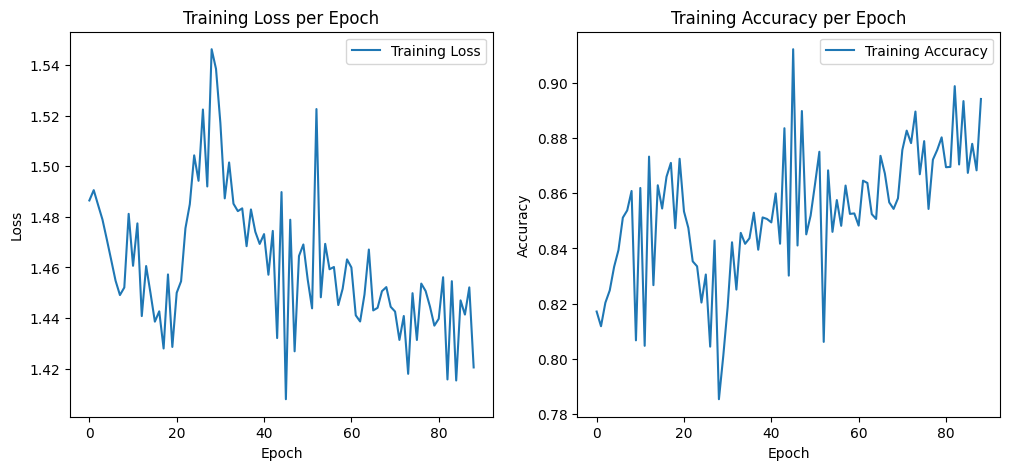

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [18]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.8190602204077368 , Precision:  0.4252034971359662 , Recall:  0.8913043478260869 , F1:  0.5757439686492224


Save model

In [19]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_{current_time}.pt"
torch.save(model.state_dict(), model_filename)

print("Model saved as:", model_filename)

Model saved as: model_2023-11-20_16-01-21.pt
